<a href="https://colab.research.google.com/github/Naga-SDonepudi/PyTorch_HandsOn/blob/main/5_custom_datasets_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Working with custom datasets using PyTorch

### 1. Setting up device agnostic code
* Before jumping into main step, PyTorch has different existing data loading functions for each problem
  * If the data is vision, look into TorchVision
  * If the data is text, then TorchText followed by TorchAudio and TorchRec for audio and recommendation problems respectively.


In [1]:
import torch
from torch import nn

torch.__version__

'2.9.0+cpu'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2. Gathering the data
* Used Food101 dataset by creating a subset.
* The original dataset has 101 classes / categories with 1000 images in each class
* The custom data i have created will be with 3 classes and 100 images per each class(75 train inages & 25 for testing)
* Always a good idea to start with smaller data, then increasing the scale when required.

In [3]:
import requests
import zipfile
from pathlib import Path

# Data Path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} skipping the download, as directory exists")
else:
  print(f"{image_path} creating a directory")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

# Unzipping the fil
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi related data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi creating a directory
Unzipping pizza, steak and sushi related data


### 3. Data preparation, pre-processing and exploration

In [4]:
import os
def walk_through_directory(dir_path):
  """
  Returns the content of every single directory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images '{dirpath}'.")

In [5]:
walk_through_directory(image_path)

There are 2 directories and 0 images 'data/pizza_steak_sushi'.
There are 3 directories and 0 images 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images 'data/pizza_steak_sushi/test/steak'.


In [6]:
### Training an testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing the image


Random Image Path: data/pizza_steak_sushi/train/pizza/2811032.jpg
Image Class: pizza
Image Height: 512
Image width: 512


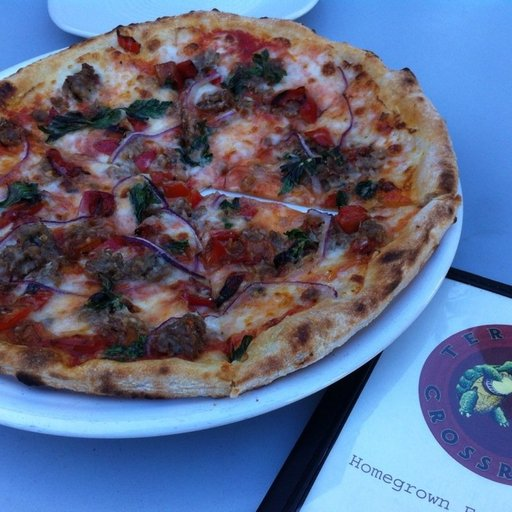

In [31]:
import random
from PIL import Image

# random.seed(42)

## Getting the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

## picking and selecting a random image
random_image = random.choice(image_path_list)

## Image class from path name
image_class = random_image.parent.stem

## Opening and Viewing the image using PIL (Python Image Library)
img = Image.open(random_image)

## Printing metadata
print(f"Random Image Path: {random_image}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image width: {img.width}")

img

### Visualizing the image using matplotlib

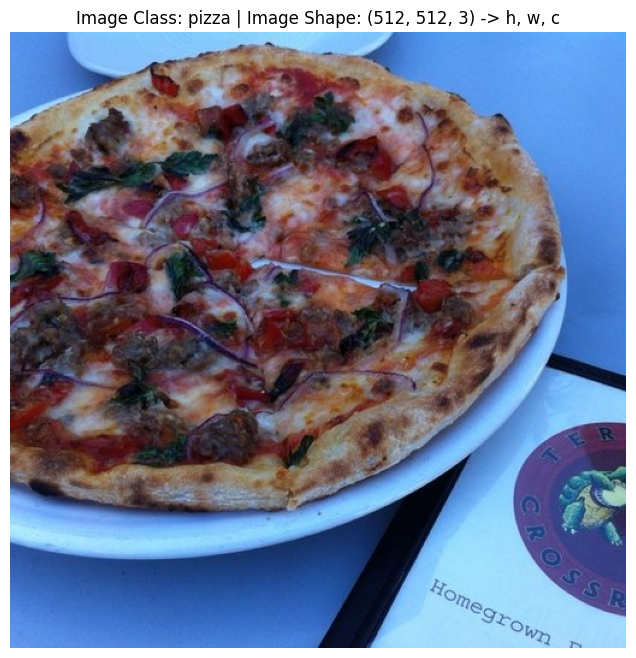

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Image to array
img_to_array = np.asarray(img)

# Plotting the image
plt.figure(figsize=(10, 8))
plt.imshow(img_to_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_to_array.shape} -> h, w, c")
plt.axis(False)
plt.show()

array([[[ 80, 150, 236],
        [ 79, 149, 235],
        [ 79, 149, 235],
        ...,
        [ 82, 167, 247],
        [ 82, 169, 248],
        [ 84, 171, 250]],

       [[ 78, 148, 234],
        [ 78, 148, 234],
        [ 78, 148, 234],
        ...,
        [ 82, 167, 247],
        [ 84, 169, 249],
        [ 85, 170, 250]],

       [[ 79, 146, 233],
        [ 79, 146, 233],
        [ 79, 146, 233],
        ...,
        [ 85, 168, 248],
        [ 86, 169, 249],
        [ 87, 170, 250]],

       ...,

       [[ 97, 151, 241],
        [ 98, 152, 242],
        [100, 154, 244],
        ...,
        [163, 217, 255],
        [161, 215, 253],
        [159, 213, 251]],

       [[ 97, 151, 241],
        [ 99, 153, 243],
        [101, 155, 245],
        ...,
        [161, 215, 253],
        [160, 214, 252],
        [160, 214, 252]],

       [[ 96, 150, 240],
        [ 99, 153, 243],
        [101, 155, 245],
        ...,
        [158, 212, 250],
        [159, 213, 251],
        [161, 215, 253]]], dtype=uint8)
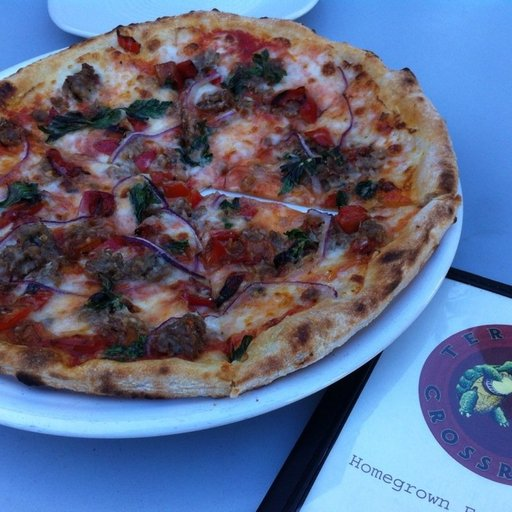

In [33]:
img_to_array

### 4. Turning images to PyTorch tensors and transforming
* Numerical representation of images
* Turning to *torch.utils.data.DataSet* and simultaneously turning dataset into *torch.utils.data.DataLoader*
* torch.utils.data.DataSet to house all the data to tensor format
* torch.utils.data.DataLoader creates an iterable or a batched version of dataset

In [34]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with torchvision.transforms
* Helps to get the inages ready to be used with a model augmentation

In [36]:
### Transforming data with torchvision.transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [53]:
data_transform(img)

tensor([[[0.3216, 0.3137, 0.3098,  ..., 0.3765, 0.3686, 0.3569],
         [0.3333, 0.3255, 0.3176,  ..., 0.3765, 0.3725, 0.3647],
         [0.3412, 0.3294, 0.3216,  ..., 0.3765, 0.3725, 0.3647],
         ...,
         [0.3451, 0.3333, 0.3216,  ..., 0.6353, 0.6392, 0.6353],
         [0.3608, 0.3529, 0.3490,  ..., 0.6353, 0.6392, 0.6431],
         [0.3765, 0.3686, 0.3608,  ..., 0.6353, 0.6353, 0.6353]],

        [[0.5765, 0.5725, 0.5686,  ..., 0.6667, 0.6588, 0.6510],
         [0.5725, 0.5686, 0.5608,  ..., 0.6431, 0.6392, 0.6392],
         [0.5804, 0.5686, 0.5569,  ..., 0.6353, 0.6314, 0.6314],
         ...,
         [0.5608, 0.5490, 0.5412,  ..., 0.8549, 0.8510, 0.8471],
         [0.5765, 0.5686, 0.5647,  ..., 0.8510, 0.8549, 0.8549],
         [0.5882, 0.5843, 0.5765,  ..., 0.8471, 0.8471, 0.8471]],

        [[0.9216, 0.9176, 0.9176,  ..., 0.9882, 0.9843, 0.9765],
         [0.9216, 0.9176, 0.9098,  ..., 0.9765, 0.9765, 0.9725],
         [0.9255, 0.9176, 0.9059,  ..., 0.9725, 0.9686, 0.

### 5. Loading Image data using ImageFolder
* ImageFolder is an pre-built datasets function
* Load / Transform image classification data using *torchvision.datasets.ImageFolder*

In [57]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, ## Transforming the ip data
                                  target_transform=None) ## Tranforming the label data

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [62]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}